In [1]:
import numpy as np
import seaborn as sns
import os
import re
import h5py
import csv
import matplotlib.pyplot as plt
import glob
sns.set()
# sns.set_style("whitegrid", {'axes.grid' : False})

import scipy
import scipy.integrate
import scipy.special as special
from scipy import interpolate
from scipy.signal import find_peaks

# Update plotting parameters
params = {'legend.fontsize': 'x-large',         
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.sans-serif': "Arial",
          'font.family': "sans-serif",
          'figure.figsize': (6, 6),
         }
plt.rcParams.update(params)

In [2]:
## Physics modeling

ħ = 1.05e-34;
qe = 1.60e-19;
ϵ0 = 8.85e-12;
c0 = 3.00e8;
kb = 1.38e-23;
evtorads = 1.52e15;

def planck(ω,T,μ):
    Θ = ħ*ω/(np.exp((ħ*ω-μ)/kb/T)-1);
    return Θ

def imeps(ω,n,d,ω0,σ):
    imeps = np.pi*((n*d**2)/(ϵ0*ħ))*np.exp(-0.5*((ω-ω0)/σ)**2)/np.sqrt(2*(np.pi)*σ**2);
    return imeps

def wl(ω):
    wl = 2*(np.pi)*c0/ω;
    return wl

# Model from DFT 
def cl_spec3(λvec,imeps,Veff):
    prefactor = np.divide(ħ*(4*np.pi**2)*(c0**2),λvec**3)
    V_factor = np.divide(Veff,λvec**3)
    cl_spec = np.multiply(imeps,V_factor);
    cl_spec = np.multiply(prefactor,cl_spec)
    return cl_spec

In [3]:
# Simple function to plot spectra
def plot_spectra(spectra_dict, curr_norm_flag = False, color = None):
    if curr_norm_flag:
        p = plt.plot(spectra_dict['wl'], spectra_dict['lint']/spectra_dict['dict']['curr'], label = spectra_dict["dict"]["caption"], linewidth = 1.0, color = color)
        prev_color = p[0].get_color()
        p = plt.fill_between(spectra_dict['wl'], (spectra_dict['lint']+spectra_dict['err'])/spectra_dict['dict']["curr"], (spectra_dict['lint']-spectra_dict['err'])/spectra_dict['dict']["curr"], alpha = 0.3, color = prev_color)
    else:
        p = plt.plot(spectra_dict['wl'], spectra_dict['lint'], label = spectra_dict["dict"]["caption"])

## Reads experimental data

Text(0, 0.5, 'Signal PSD (W/nm)')

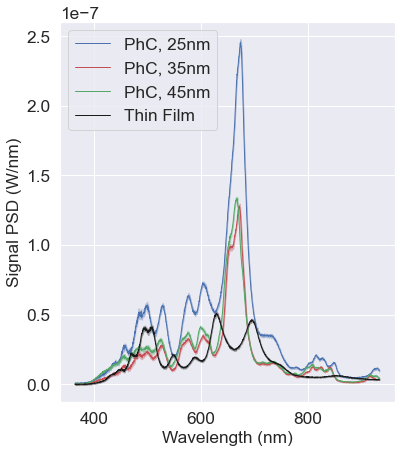

In [4]:
# Reading Experimental files
etch_25nm = np.load('exptdata/thick4_Olympus_10int 2020 July 30 15_08_28.npy', allow_pickle = True).item()
etch_25nm["dict"]["caption"] = "PhC, 25nm"
etch_35nm = np.load('exptdata/thick3_Olympus_10int 2020 July 30 14_53_34.npy', allow_pickle = True).item()
etch_35nm["dict"]["caption"] = "PhC, 35nm"
etch_45nm = np.load('exptdata/thick2_Olympus_10int 2020 July 30 14_51_15.npy', allow_pickle = True).item()
etch_45nm["dict"]["caption"] = "PhC, 45nm"
etch_0nm = np.load('exptdata/unpat_Olympus_10int 2020 July 30 14_46_48.npy', allow_pickle = True).item()
etch_0nm["dict"]["caption"] = "Thin Film"

specs = np.zeros((5,len(etch_25nm['lint'])));
specs[1,:] = etch_45nm['lint'] # thick 45
specs[2,:] = etch_35nm['lint'] # thick 35
specs[3,:] = etch_25nm['lint'] # thick 25
specs[4,:] = etch_0nm['lint'] # thick 0

spectrawl = etch_0nm['wl']

plt.figure(figsize = (6,7))
plot_spectra(etch_25nm, curr_norm_flag = True, color='b')
plot_spectra(etch_35nm, curr_norm_flag = True, color='r')
plot_spectra(etch_45nm, curr_norm_flag = True, color='g')
plot_spectra(etch_0nm, curr_norm_flag = True, color='k')
plt.legend()
plt.xlabel('Wavelength (nm)')       
plt.ylabel('Signal PSD (W/nm)')

Comparing normalized PSD at wl = 673.6853002749272 nm, 25nm to 0 nm = 5.971107375499053
Comparing normalized PSD at max. wl, 25nm to 0 nm = 3.3357941302678626
Comparing normalized integrated PSD from in range [635, 695]nm, 25nm to 0 nm = 3.072684659152947


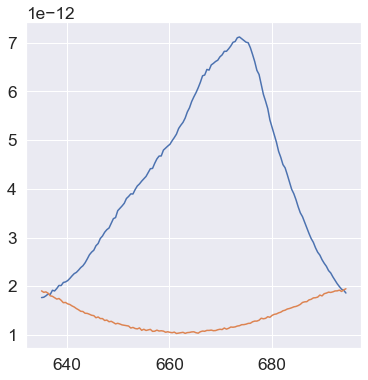

In [5]:
# Let's compare scintillation from various spectra

# Comparing scintillation at max frequency from thick 4 
max_scint_25nm = np.where(etch_25nm['lint']==np.max(etch_25nm['lint']))[0][0]
FOM1_25nm = etch_25nm['lint'][max_scint_25nm]
FOM1_0nm = etch_0nm['lint'][max_scint_25nm]

print("Comparing normalized PSD at wl = {0} nm, 25nm to 0 nm = {1}".format(etch_0nm['wl'][max_scint_25nm], FOM1_25nm/FOM1_0nm))

# Comparing scintillation at max frequency (each thickness has its own)
max_scint_0nm = np.where(etch_0nm['lint']==np.max(etch_0nm['lint']))[0][0]
FOM2_25nm = etch_25nm['lint'][max_scint_25nm]
FOM2_0nm = etch_0nm['lint'][max_scint_0nm]

print("Comparing normalized PSD at max. wl, 25nm to 0 nm = {0}".format(FOM2_25nm/FOM2_0nm))

# Comparing integrated scintillation power in a bandwidth
wlmin = 635
wlmax = 695
indwlmin = np.where(np.abs(etch_0nm['wl']-wlmin)==np.min(np.abs(etch_0nm['wl']-wlmin)))[0][0]
indwlmax = np.where(np.abs(etch_0nm['wl']-wlmax)==np.min(np.abs(etch_0nm['wl']-wlmax)))[0][0]
wl_red = etch_0nm['wl'][indwlmin:indwlmax]
spec_25nm_red = etch_25nm['lint'][indwlmin:indwlmax]
spec_0nm_red = etch_0nm['lint'][indwlmin:indwlmax]

FOM3_25nm = np.trapz(spec_25nm_red,wl_red)
FOM3_0nm = np.trapz(spec_0nm_red,wl_red)

print("Comparing normalized integrated PSD from in range [{0}, {1}]nm, 25nm to 0 nm = {2}".format(wlmin, wlmax, FOM3_25nm/FOM3_0nm))

plt.plot(wl_red, spec_25nm_red)
plt.plot(wl_red, spec_0nm_red)

## Reads RCWA data

In [6]:
def read_single_file(data_file):    
    return np.load(data_file, allow_pickle = True)

In [7]:
# Loads RCWA data 
folder_name = "./rcwares/"
data0 = read_single_file(folder_name +"rcwa_expt_analysis_etchdepth_0.0nm.npy")
wl_vec = data0.item().get("wl_vec")
pol_vec = {"s", "p"}
theta_vec = data0.item().get("theta_vec")
theta_mat = data0.item().get("theta_mat")
phi_mat = data0.item().get("phi_mat")
meas_depth_vec = data0.item().get("meas_depth_vec")
thick_SiO2 = data0.item().get("thick_SiO2")
rad_etch = data0.item().get("rad_etch")
args0 = data0.item().get("args")
# data_mat has size (len(wl_vec), len(theta_vec), len(theta_vec), len(pol_vec), len(meas_depth_vec)))
data_mat0 = data0.item().get("data_mat") 

data25 = read_single_file(folder_name +"rcwa_expt_analysis_etchdepth_25.0nm.npy")
args25 = data25.item().get("args")
data_mat25 = data25.item().get("data_mat") 

data35 = read_single_file(folder_name +"rcwa_expt_analysis_etchdepth_35.0nm.npy")
args35 = data35.item().get("args")
data_mat35 = data35.item().get("data_mat") 

data45 = read_single_file(folder_name +"rcwa_expt_analysis_etchdepth_45.0nm.npy")
args45 = data45.item().get("args")
data_mat45 = data45.item().get("data_mat") 

In [8]:
def symmetrize(M, sizes):    
    ## For triangular sweep: fills map with symmetry (here C4v)
    # First, fill other half of array (which is empty) with pi/4 mirror symmetry
    M0 = M[:] #Makes a copy 
    for ii in range(np.shape(M)[1]):
        for jj in range(np.shape(M)[2]):
            if np.all(M0[:,ii,jj,:] == 0):
                # C_{4v} symmetry enforced here: pay attention to (x,y) permutation! 
                M0[:,ii,jj,0] = M0[:,jj,ii,1]
                M0[:,ii,jj,1] = M0[:,jj,ii,0]

    # Then concatenate copies of LDOS0
    new_sizes = list(sizes)
    new_sizes[1] = 2*sizes[1]
    new_sizes[2] = 2*sizes[2]
    new_sizes = tuple(new_sizes)
    M_sym = np.zeros(new_sizes)
    for ii in range(np.shape(M_sym)[1]):
        ii0 = int(np.abs(ii - np.shape(M)[1] + 0.5))
        for jj in range(np.shape(M_sym)[2]):
            jj0 = int(np.abs(jj - np.shape(M)[2] + 0.5))
            M_sym[:,ii,jj,:] = M0[:,ii0,jj0,:]             
    M_sym = np.delete(M_sym, new_sizes[1]//2, axis = 1) # removes 0 angle that is counted twice otherwise
    M_sym = np.delete(M_sym, new_sizes[2]//2, axis = 2)    
    return M_sym

# Symmetrize data for angular plot visualization
data_mat0sym = symmetrize(data_mat0, np.shape(data_mat0))
data_mat25sym = symmetrize(data_mat25, np.shape(data_mat25))
data_mat35sym = symmetrize(data_mat35, np.shape(data_mat35))
data_mat45sym = symmetrize(data_mat45, np.shape(data_mat45))

def remove_ticks(ax, tick_spacing, num_ticks):
    for (labelx, labely, ind) in zip(ax.get_xticklabels(), ax.get_yticklabels(), range(num_ticks)):
        if not(ind % tick_spacing) == 0 and not(ind == num_ticks-1):
            labelx.set_visible(False)
            labely.set_visible(False)            

def plot_map(wl, wlind, data, xvec_sym, yvec_sym, tick_spacing, meas_depth_ind, flag_str = "", show_flag = True):
    print("Reading wavelength: " + str(wl[wlind]*1e3))
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    data_spacemap = np.squeeze(data[wlind,:,:,0,meas_depth_ind])
    sns.set()
    axs[0] = sns.heatmap(data_spacemap, ax = axs[0], xticklabels = np.round(xvec_sym, 3), yticklabels = np.round(yvec_sym, 3), square = True)
    axs[0].title.set_text('Polarization X')
    remove_ticks(axs[0], tick_spacing, len(xvec_sym))

    data_spacemap = np.squeeze(data[wlind,:,:,1,meas_depth_ind])
    axs[1] = sns.heatmap(data_spacemap, ax = axs[1], xticklabels = np.round(xvec_sym, 3), yticklabels = np.round(yvec_sym, 3), square = True)
    axs[1].title.set_text('Polarization Y')
    remove_ticks(axs[1], tick_spacing, len(xvec_sym))

    fig.suptitle('$\lambda$ = ' + str(int(wl[wlind]*1e3)) + 'nm ' + flag_str)
    fig.subplots_adjust(top=0.82)
    if show_flag == True:
        plt.show()
    
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image
    
thetaxvec_sym = np.concatenate((np.flip(-theta_vec), theta_vec[1:]))
thetayvec_sym = thetaxvec_sym
tick_spacing = 32

# Experimental : Multiply data by angular filter
theta_matsym = np.repeat(theta_mat[np.newaxis, :, :], len(wl_vec), axis = 0)
theta_matsym = np.repeat(theta_matsym[:, :, :, np.newaxis], len(pol_vec), axis = 3)
theta_matsym = np.repeat(theta_matsym[:, :, :, :, np.newaxis], len(meas_depth_vec), axis = 4)

phi_matsym = np.repeat(phi_mat[np.newaxis, :, :], len(wl_vec), axis = 0)
phi_matsym = np.repeat(phi_matsym[:, :, :, np.newaxis], len(pol_vec), axis = 3)
phi_matsym = np.repeat(phi_matsym[:, :, :, :, np.newaxis], len(meas_depth_vec), axis = 4)

theta_matsym = symmetrize(theta_matsym, np.shape(theta_matsym))
phi_matsym = symmetrize(phi_matsym, np.shape(phi_matsym))

theta_matx = np.multiply(theta_matsym, np.cos(phi_matsym))
theta_maty = np.multiply(theta_matsym, np.sin(phi_matsym))

def angle_filter(offset,theta_std):
    filter_sym = np.exp(-((theta_matsym - offset)**2.)/2./theta_std**2.)/theta_std/np.sqrt(2*np.pi)
    filter_sym = filter_sym/np.sum(np.sum(filter_sym[np.where(data_mat0sym[200, :, :, 0, 0] != 0)]))
    return filter_sym

def angle_filter_xy(offsetx,offsety,theta_std):
    filter_sym = np.exp(-((theta_matsym - offset)**2.)/2./theta_std**2.)/theta_std/np.sqrt(2*np.pi)
    filter_sym = filter_sym/np.sum(np.sum(filter_sym[np.where(data_mat0sym[200, :, :, 0, 0] != 0)]))
    return filter_sym

num_angles = len(np.where(data_mat0sym[200, :, :, 0, 0] != 0)[0])

In [9]:
## Loads and process data from CASINO Simulations 
data = np.loadtxt('casinores/cl_by_z_89deg_40kv_250ke.dat');
positions = data[:,0];
dEdz = data[:,1];

kmin = 80;
kmax = 260;
zmean = np.sum(np.multiply(positions[kmin:kmax],dEdz[kmin:kmax]))/np.sum(dEdz[kmin:kmax])

dEdz_cond = dEdz[kmin:kmax] / np.sum(dEdz[kmin:kmax]);

dEdz_fn = scipy.interpolate.interp1d(positions[kmin:kmax],dEdz_cond);

en_loss_sio2 = dEdz_fn(500+meas_depth_vec*1000);

In [10]:
## Calculates Veff from simulation data 

# Wavelength 
wlvec_nm = np.arange(400,800,1);
wlvec = 1e-9*wlvec_nm;
ωvec = np.divide(2*np.pi*c0, wlvec);

# Angular offset fits
offset0 = 8*np.pi/180;
offset25 = -8*np.pi/180;
offset35 = 8*np.pi/180;
offset45 = 8*np.pi/180;

sigma = (17.5/2/2.355)*np.pi/180;

# Max depth index 
dmax = 10;

filter_sym0 = angle_filter(offset0,sigma);
filter_sym25 = angle_filter(offset25,sigma);
filter_sym35 = angle_filter(offset35,sigma);
filter_sym45 = angle_filter(offset45,sigma);

# Applies angular filters
data_mat0avg = np.squeeze(np.sum(np.sum(data_mat0sym*filter_sym0,1),1))/num_angles
data_mat25avg = np.squeeze(np.sum(np.sum(data_mat25sym*filter_sym25,1),1))/num_angles
data_mat35avg = np.squeeze(np.sum(np.sum(data_mat35sym*filter_sym35,1),1))/num_angles
data_mat45avg = np.squeeze(np.sum(np.sum(data_mat45sym*filter_sym45,1),1))/num_angles

# Normalizes to max thickness 
data_0_zsum = np.sum(data_mat0avg[:,:,0:dmax],2)/(dmax+1);
data_0_zsum[:,0] = np.divide(data_0_zsum[:,0], (1e-6)*wl_vec);
data_0_zsum[:,1] = np.divide(data_0_zsum[:,1], (1e-6)*wl_vec);

data_25_zsum = np.sum(data_mat25avg[:,:,0:dmax],2)/(dmax+1);
data_25_zsum[:,0] = np.divide(data_25_zsum[:,0], (1e-6)*wl_vec);
data_25_zsum[:,1] = np.divide(data_25_zsum[:,1], (1e-6)*wl_vec);

data_35_zsum = np.sum(data_mat35avg[:,:,0:dmax],2)/(dmax+1);
data_35_zsum[:,0] = np.divide(data_35_zsum[:,0], (1e-6)*wl_vec);
data_35_zsum[:,1] = np.divide(data_35_zsum[:,1], (1e-6)*wl_vec);

data_45_zsum = np.sum(data_mat45avg[:,:,0:dmax],2)/(dmax+1);
data_45_zsum[:,0] = np.divide(data_45_zsum[:,0], (1e-6)*wl_vec);
data_45_zsum[:,1] = np.divide(data_45_zsum[:,1], (1e-6)*wl_vec);

# Extract polarization-sensitive Veff's 
Veff0s = data_0_zsum[:,0];
Veff0p = data_0_zsum[:,1];

Veff25s = data_25_zsum[:,0];
Veff25p = data_25_zsum[:,1];

Veff35s = data_35_zsum[:,0];
Veff35p = data_35_zsum[:,1];

Veff45s = data_45_zsum[:,0];
Veff45p = data_45_zsum[:,1];

# Spectral functions S(\omega)
vol = 1;
imepsfn_r = imeps(np.divide(2*np.pi*c0,wlvec),1/vol,qe*(1.06e-10),1.95*evtorads,(0.25/2.355)*evtorads)
imepsfn_g = imeps(np.divide(2*np.pi*c0,wlvec),1/vol,qe*(1.06e-10),2.6*evtorads,(1.2/2.355)*evtorads)

# Calculates scintillation spectra 
nd = 1;

# Red peaks 
cl_spec0_r = cl_spec3(wlvec,nd*imepsfn_r,vol*(Veff0s+Veff0p))
norm = np.max(cl_spec0_r);

cl_spec0_r = cl_spec0_r / norm;

cl_spec25_r = cl_spec3(wlvec,nd*imepsfn_r,vol*(Veff25s+Veff25p))
cl_spec25_r = cl_spec25_r / norm;

cl_spec35_r = cl_spec3(wlvec,nd*imepsfn_r,vol*(Veff35s+Veff35p))
cl_spec35_r = cl_spec35_r / norm;

cl_spec45_r = cl_spec3(wlvec,nd*imepsfn_r,vol*(Veff45s+Veff45p))
cl_spec45_r = cl_spec45_r / norm;

# Green peaks 
cl_spec0_g = cl_spec3(wlvec,nd*imepsfn_g,vol*(Veff0s+Veff0p))
norm = np.max(cl_spec0_g);

cl_spec0_g = cl_spec0_g / norm;

cl_spec25_g = cl_spec3(wlvec,nd*imepsfn_g,vol*(Veff25s+Veff25p))
cl_spec25_g = cl_spec25_g / norm;

cl_spec35_g = cl_spec3(wlvec,nd*imepsfn_g,vol*(Veff35s+Veff35p))
cl_spec35_g = cl_spec35_g / norm;

cl_spec45_g = cl_spec3(wlvec,nd*imepsfn_g,vol*(Veff45s+Veff45p))
cl_spec45_g = cl_spec45_g / norm;

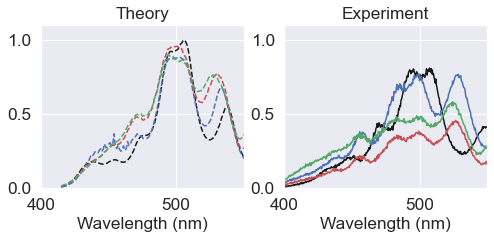

In [11]:
## Green peak only
shift_grn = 15;

fig_green_sep, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(wl_vec*1e3 + shift_grn,cl_spec0_g,'k--')
axs[0].plot(wl_vec*1e3 + shift_grn,cl_spec25_g,'b--')
axs[0].plot(wl_vec*1e3 + shift_grn,cl_spec35_g,'r--')
axs[0].plot(wl_vec*1e3 + shift_grn,cl_spec45_g,'g--')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].title.set_text('Theory')
axs[0].set_xlim([400,550])
axs[0].set_ylim([0,1.1])
axs[0].set_xticks([400,500])

axs[1].plot(spectrawl[0:1040],specs[4,0:1040]/np.max(specs[4,0:1340]),'k-')
axs[1].plot(spectrawl[0:1040],specs[3,0:1040]/np.max(specs[4,0:1340]),'b-')
axs[1].plot(spectrawl[0:1040],specs[2,0:1040]/np.max(specs[4,0:1340]),'r-')
axs[1].plot(spectrawl[0:1040],specs[1,0:1040]/np.max(specs[4,0:1340]),'g-')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].title.set_text('25 nm')
axs[1].title.set_text('Experiment')
axs[1].set_xlim([400,550])
axs[1].set_ylim([0,1.1])
axs[1].set_xticks([400,500])

(0.0, 1.1)

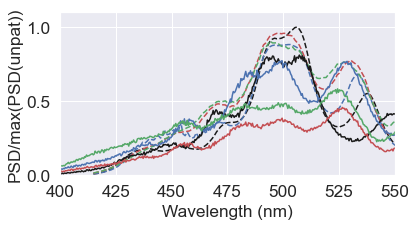

In [12]:
fig_green_same = plt.figure(figsize=(6, 3))
plt.plot(wl_vec*1e3 + shift_grn,cl_spec0_g, 'k--')
plt.plot(wl_vec*1e3 + shift_grn,cl_spec25_g, 'b--')
plt.plot(wl_vec*1e3 + shift_grn,cl_spec35_g, 'r--')
plt.plot(wl_vec*1e3 + shift_grn,cl_spec45_g,'g--')
plt.plot(spectrawl[0:1040],specs[4,0:1040]/np.max(specs[4,0:1340]),'k-')
plt.plot(spectrawl[0:1040],specs[3,0:1040]/np.max(specs[4,0:1340]),'b-')
plt.plot(spectrawl[0:1040],specs[2,0:1040]/np.max(specs[4,0:1340]),'r-')
plt.plot(spectrawl[0:1040],specs[1,0:1040]/np.max(specs[4,0:1340]),'g-')

plt.xlabel('Wavelength (nm)')
plt.ylabel("PSD/max(PSD(unpat))")
plt.xlim([400,550])
plt.ylim([0,1.1])

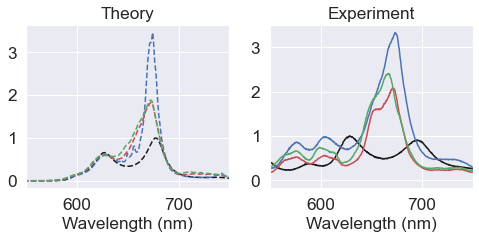

In [13]:
## Red peak only 
shift_red = 35;

fig_red_sep, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(wl_vec*1e3 + shift_red,cl_spec0_r,'k--')
axs[0].plot(wl_vec*1e3 + shift_red,cl_spec25_r,'b--')
axs[0].plot(wl_vec*1e3 + shift_red,cl_spec35_r,'r--')
axs[0].plot(wl_vec*1e3 + shift_red,cl_spec45_r,'g--')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].title.set_text('Theory')
axs[0].set_xlim([550,750])
axs[0].set_xticks([600,700])

axs[1].plot(spectrawl[0:1040],specs[4,0:1040]/np.max(specs[4,0:1340]),'k-')
axs[1].plot(spectrawl[0:1040],specs[3,0:1040]/np.max(specs[4,0:1340]),'b-')
axs[1].plot(spectrawl[0:1040],specs[2,0:1040]/np.max(specs[4,0:1340]),'r-')
axs[1].plot(spectrawl[0:1040],specs[1,0:1040]/np.max(specs[4,0:1340]),'g-')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].title.set_text('25 nm')
axs[1].title.set_text('Experiment')
axs[1].set_xlim([550,750])
axs[1].set_xticks([600,700])

(600.0, 725.0)

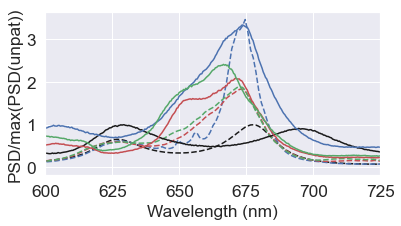

In [14]:
fig_red_same = plt.figure(figsize=(6,3))

plt.plot(wl_vec*1e3 + shift_red,cl_spec0_r,linestyle='--',color='k')
plt.plot(wl_vec*1e3 + shift_red,cl_spec25_r,linestyle='--',color='b')
plt.plot(wl_vec*1e3 + shift_red,cl_spec35_r,linestyle='--',color='r')
plt.plot(wl_vec*1e3 + shift_red,cl_spec45_r,linestyle='--',color='g')

plt.plot(spectrawl[0:1040],specs[4,0:1040]/np.max(specs[4,0:1340]),linestyle='-',color='k')
plt.plot(spectrawl[0:1040],specs[3,0:1040]/np.max(specs[4,0:1340]),linestyle='-',color='b')
plt.plot(spectrawl[0:1040],specs[2,0:1040]/np.max(specs[4,0:1340]),linestyle='-',color='r')
plt.plot(spectrawl[0:1040],specs[1,0:1040]/np.max(specs[4,0:1340]),linestyle='-',color='g')

plt.xlabel('Wavelength (nm)')
plt.ylabel("PSD/max(PSD(unpat))")
plt.xlim([600,725])

# Figures for the manuscript 

Veff inset for Fig. 2 showing enhancement at normal incidence

(400.0, 800.0)

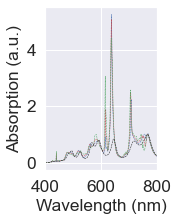

In [15]:
fig_veff = plt.figure(figsize=(2, 3))
dmax = 10
lw = 0.5
amax = np.max(np.sum(data_mat0sym[:,19,19,0,0:dmax],1)/(dmax+1));
plt.plot(wl_vec*1e3,np.sum(data_mat25sym[:,19,19,0,0:dmax],1)/(dmax+1)/amax,linestyle='--',linewidth=lw,color='b')
plt.plot(wl_vec*1e3,np.sum(data_mat35sym[:,19,19,0,0:dmax],1)/(dmax+1)/amax,linestyle='--',linewidth=lw,color='r')
plt.plot(wl_vec*1e3,np.sum(data_mat45sym[:,19,19,0,0:dmax],1)/(dmax+1)/amax,linestyle='--',linewidth=lw,color='g')
plt.plot(wl_vec*1e3,np.sum(data_mat0sym[:,19,19,0,0:dmax],1)/(dmax+1)/amax,linestyle='--',linewidth=lw,color='k')
plt.xlabel('Wavelength (nm)')
plt.ylabel("Absorption (a.u.)")
plt.xlim([400,800])

CASINO energy loss data (line plot, I think the 2D plots have too weird of an aspect ratio to be illuminating.) 

Text(0, 0.5, 'dE/dz (a.u)')

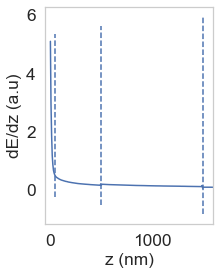

In [16]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(3,4))
data = np.loadtxt('casinores/cl_by_z_89deg_40kv_250ke.dat');
positions = data[:,0];
dEdz = data[:,1];
plt.plot(positions,dEdz)
plt.vlines(50, plt.ylim()[0], plt.ylim()[1], linestyle = '--')
plt.vlines(500, plt.ylim()[0], plt.ylim()[1], linestyle = '--')
plt.vlines(1500, plt.ylim()[0], plt.ylim()[1], linestyle = '--')
plt.xlim(-50,1600)
plt.xlabel("z (nm)")
plt.ylabel("dE/dz (a.u)")

Text(0, 0.5, 'dE/dz (a.u)')

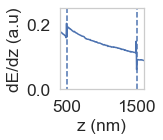

In [17]:
plt.figure(figsize=(1.5,1.5))

plt.plot(positions,dEdz)
plt.xlim(400,1600)
plt.vlines(500, plt.ylim()[0], plt.ylim()[1], linestyle = '--')
plt.vlines(1500, plt.ylim()[0], plt.ylim()[1], linestyle = '--')
plt.ylim(0,0.25)
plt.xlabel("z (nm)")
plt.xticks([500,1500])
plt.ylabel("dE/dz (a.u)")

Theory vs. experiment (red) [same plot]

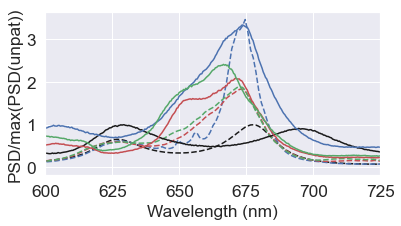

In [18]:
fig_red_same

Theory vs. experiment (red) [different plots]

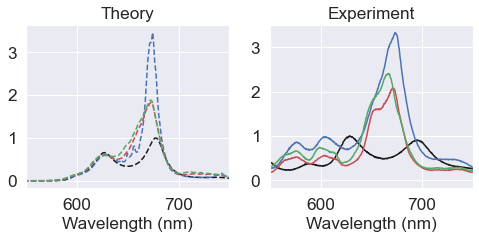

In [19]:
fig_red_sep

In [20]:
## Show w/ shift of one wrt the other

Theory vs. experiment (green) [same plot]

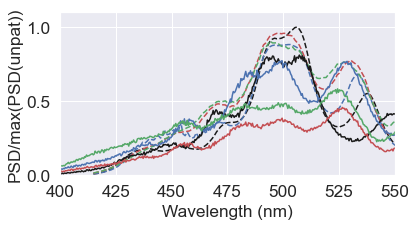

In [21]:
fig_green_same

Theory vs. experiment (green) [different plots]

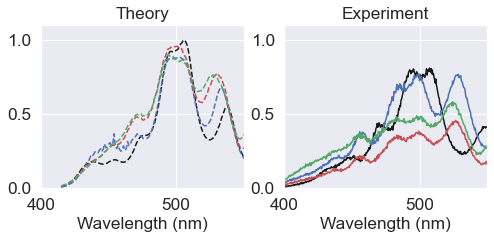

In [22]:
fig_green_sep